# data import

In [0]:
pip install scikit-plot

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
#import s3fs
import io
import scikitplot as skplt


sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1cU3oUaNJ40Wjep7SPHm0CtI5gHuYPxbG' # The shareable link

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1cU3oUaNJ40Wjep7SPHm0CtI5gHuYPxbG


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_not_combined.csv')  
df_not_combined = pd.read_csv('df_not_combined.csv', index_col = 0)

In [0]:
link = 'https://drive.google.com/open?id=17dtLL1n-RiotL5R7AOserCkleydPdex9'

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

17dtLL1n-RiotL5R7AOserCkleydPdex9


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_combined.csv')  
df_combined = pd.read_csv('df_combined.csv', index_col = 0)

# modelling packages

In [0]:
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.utils.class_weight import compute_class_weight

In [0]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object", "ref_pos":"object"})

In [0]:
seed = 7

## train test split

In [0]:
# manual train test split according to ref_num to preserve sequence sequence identity
# maybe do it according to read_num to increase variability?

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
train_ref = ["ref_0000","ref_0001","ref_0002"]
test_ref = ["ref_0003"]

In [0]:
# prepare whole dataframe subsets according to train test split

df_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
df_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
df_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
df_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]

In [0]:
# prepare whole dataframe subsets according to train test split

df_finaltest_combined = df_combined[df_combined["ref_number"].isin(final_ref)]
df_val_combined = df_combined[df_combined["ref_number"].isin(val_ref)]
df_train_combined = df_combined[df_combined["ref_number"].isin(train_ref)]
df_test_combined = df_combined[df_combined["ref_number"].isin(test_ref)]

In [0]:
# function to get dataframe into x and y array with format (reads, ref_pos, features) to be able use ref_pos
# as time step in rnn

def prepare_rnn_data (df):
     
    # dummify base sequence and concatenate into temp dataframe with numeric values from source dataframe
    
    df_dum = pd.get_dummies(df[["base_1","base_2","base_3","base_4","base_5"]])
    df_dum = pd.concat([df, df_dum], axis = 1)
    df_dum = df_dum.drop(["base_1","base_2","base_3","base_4","base_5"], axis = 1)
    
    df_dum_num = df_dum[df_dum.select_dtypes(include=[np.number]).columns.values]
    
    # feature 3d array:
    # nested for loop over file name, ref_num and read_num to iterate over every unique possible read and concatenate
    # x and y values into a list of lists
    
    X = []
    y= []
    
    for file_name in df_dum.file_name.unique():
        msk1 = df_dum[df_dum.file_name == file_name]
        for ref_num in msk1.ref_number.unique():
            msk2 = msk1[msk1.ref_number == ref_num]
            for read_num in msk2.read_num.unique():
                msk3 = (df_dum.file_name == file_name) & (df_dum.ref_number == ref_num) & (df_dum.read_num == read_num)
                X.append(df_dum_num[msk3])
                y.append(df_dum[msk3].modified_status.astype(int))
  
    #stack resulting lists into a 3d numpy array
    
    X = np.stack(X)
    y = np.stack(y)
    
    return X, y

In [0]:
# function to get dataframe into x and y array with format (reads, ref_pos, features) to be able use ref_pos
# as time step in rnn

def prepare_rnn_data2 (df):
     
    # dummify base sequence and concatenate into temp dataframe with numeric values from source dataframe
    
    df_dum = pd.get_dummies(df[["base_1","base_2","base_3","base_4","base_5"]])
    df_dum = pd.concat([df, df_dum], axis = 1)
    df_dum = df_dum.drop(["base_1","base_2","base_3","base_4","base_5"], axis = 1)
    
    df_dum_num = df_dum[df_dum.select_dtypes(include=[np.number]).columns.values]
    
    # feature 3d array:
    # nested for loop over file name, ref_num and read_num to iterate over every unique possible read and concatenate
    # x and y values into a list of lists
    
    X = []
    y= []
    
    for file_name in df_dum.file_name.unique():
        msk1 = df_dum[df_dum.file_name == file_name]
        for ref_num in msk1.ref_number.unique():
  
              msk3 = (df_dum.file_name == file_name) & (df_dum.ref_number == ref_num)
              X.append(df_dum_num[msk3])
              y.append(df_dum[msk3].modified_status.astype(int))
  
    #stack resulting lists into a 3d numpy array
    
    X = np.stack(X)
    y = np.stack(y)
    
    return X, y

In [0]:
# prepare each dataframe combination with function

X_3d_train, y_3d_train = prepare_rnn_data(df_train_not_combined)
X_3d_test, y_3d_test = prepare_rnn_data(df_test_not_combined)
X_3d_finaltest, y_3d_finaltest = prepare_rnn_data(df_finaltest_not_combined)
X_3d_val, y_3d_val = prepare_rnn_data(df_val_not_combined)

In [0]:
# prepare each dataframe combination with function

X_combined_train, y_combined_train = prepare_rnn_data2(df_train_combined)
X_combined_test, y_combined_test = prepare_rnn_data2(df_test_combined)
X_combined_finaltest, y_combined_finaltest = prepare_rnn_data2(df_finaltest_combined)
X_combined_val, y_combined_val = prepare_rnn_data2(df_val_combined)

# rnn not combined

In [0]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [0]:
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [0]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [0]:
class rnn_constructor():
    
    def __init__(self, model, instance_name, custom_loss_state = False, batch_size=20):
       
        self.custom_loss_state = custom_loss_state
        self.instance_name = instance_name
        self.model = model
        self.features = 1
        self.n_train = 1
        self.buffer_size = 1
        self.batch_size = batch_size
        self.steps_per_epoch = 1

        self.metrics = [tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                        #tf.keras.metrics.TruePositives(name='tp'),
                        #tf.keras.metrics.FalsePositives(name='fp'),
                        #tf.keras.metrics.TrueNegatives(name='tn'),
                        #tf.keras.metrics.FalseNegatives(name='fn'), 
                        #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        #tf.keras.metrics.Precision(name='precision'),
                        #tf.keras.metrics.Recall(name='recall'),
                        #tf.keras.metrics.AUC(name='auc')
                        ]

        self.lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                                                                          0.001,
                                                                          decay_steps=self.steps_per_epoch*500,
                                                                          decay_rate=1,
                                                                          staircase=False)
        self.history = {}
        self.class_weight=None
        self.pos_weight = None
        self.loss = None
        self.classification_report = None
   
    def __custom_loss__(self, y_actual,y_pred):
        y_actual = tf.cast(y_actual, dtype="float32")
        custom_loss=tf.nn.weighted_cross_entropy_with_logits(labels=y_actual, logits=y_pred, 
                                                             pos_weight = self.pos_weight, name="loss")
        return custom_loss
    

    def __get_class_weights__(self, y_train):
        class_weight_list = compute_class_weight("balanced", np.unique(y_train), y_train.flatten()) 
        self.class_weight = dict(zip(np.unique(y_train), class_weight_list))
    
        
    def __get_callbacks__(self):
        return [
            tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100),
                ]
    
    def __get_optimizer__(self):
      return tf.keras.optimizers.Adam(self.lr_schedule)
    
    def __model_compile__(self):
        if self.custom_loss_state:
            self.loss = self.__custom_loss__
        else:
            self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        optimizer = self.__get_optimizer__()
        self.model.compile(optimizer=optimizer,
                    loss=self.loss,
                    metrics=self.metrics,
                     )

        self.model.summary()
    
    def __model_fit__(self, X_train, y_train, X_test, y_test, epochs = 2500, class_weight = True):
        
        
        self.features = X_train.shape[2]
        self.n_train = len(X_train)
        self.buffer_size = len(X_train)
        self.steps_per_epoch = self.n_train//self.batch_size
        self.history[self.instance_name] = self.model.fit(
                                x=X_train,
                                y=y_train,
                                batch_size=self.batch_size,
                                steps_per_epoch = self.steps_per_epoch,
                                epochs=epochs,
                                validation_data=(X_test, y_test),
                                callbacks=self.__get_callbacks__(),
                                verbose=0,
                                workers = 8,
                                class_weight = self.class_weight,
                                use_multiprocessing = True,
                                shuffle=True,
                                    )
    
    def compile_and_fit(self, X_train, y_train, X_test, y_test, epochs = 2500, class_weight = True):
        
        if self.custom_loss_state == True:
            self.__get_class_weights__(y_train)
            self.pos_weight = self.class_weight[1]
            self.class_weight = None
        if class_weight == True:
            self.__get_class_weights__(y_train)
        
        
        self.__model_compile__()
        self.__model_fit__( X_train, y_train, X_test, y_test, epochs = 2500)
        return self.history
    
    def plot_training(self, metric = 'loss'):
        
        plotter = tfdocs.plots.HistoryPlotter(metric = metric, smoothing_std=10)
        plotter.plot(self.history)
        
    def plot_evaluation(self, x_train, y_train):
        y_pred = self.model.predict_classes(x_train)
        skplt.metrics.plot_confusion_matrix(y_train.flatten(),y_pred.flatten(), figsize=(10,10), text_fontsize=20)
        self.classification_report = classification_report(y_train.flatten(),y_pred.flatten(), output_dict = True)
        print(classification_report(y_train.flatten(),y_pred.flatten()))
        return {self.instance_name:self.classification_report["1"]["f1-score"]}

In [0]:
histories = {}
f1_scores = {}

In [0]:
# rnn model

model_class_weight = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(196,26),return_sequences=True),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Dense(1)
])

In [0]:
rnn_class_weight = rnn_constructor(model_class_weight, "overfit", custom_loss_state = False)

In [0]:
rnn_class_weight.batch_size

20

In [0]:
hist = rnn_class_weight.compile_and_fit(X_train = X_3d_train, y_train = y_3d_train,X_test = X_3d_test, y_test = y_3d_test, class_weight = True)
histories.update(hist)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 196, 64)           23296     
_________________________________________________________________
dropout (Dropout)            (None, 196, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 196, 256)          197632    
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 256)          0         
_________________________________________________________________
dense (Dense)                (None, 196, 1)            257       
Total params: 221,185
Trainable params: 221,185
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:0.1802,  loss:1.3914,  val_binary_crossentropy:0.1499,  val_loss:0.1499,  
..........

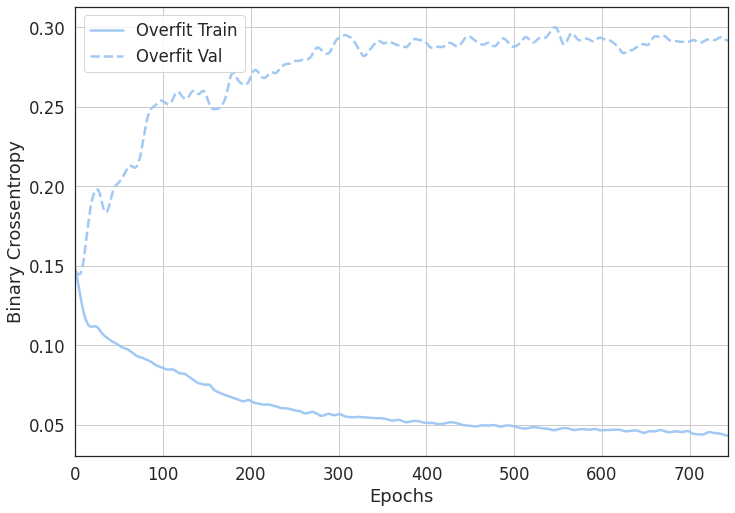

In [0]:
rnn_class_weight.plot_training("binary_crossentropy")

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     43585
           1       0.05      0.01      0.01      1495

    accuracy                           0.96     45080
   macro avg       0.51      0.50      0.50     45080
weighted avg       0.94      0.96      0.95     45080



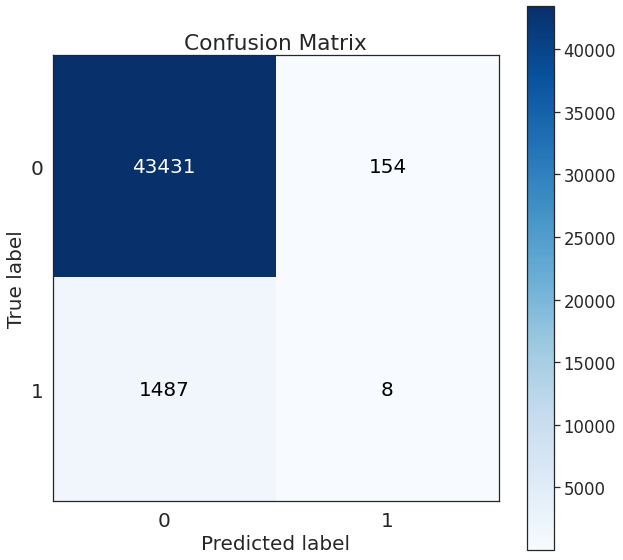

In [0]:
f1 = rnn_class_weight.plot_evaluation(X_3d_val, y_3d_val)
f1_scores.update(f1)

In [0]:
# rnn model

model_class_weight2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(196,26),return_sequences=True),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,return_sequences=True)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Dense(1)
])

In [0]:
rnn_class_weight2 = rnn_constructor(model_class_weight2, "underfit", custom_loss_state = False)

In [0]:
hist = rnn_class_weight2.compile_and_fit(X_train = X_3d_train, y_train = y_3d_train,X_test = X_3d_test, y_test = y_3d_test, class_weight = True)
histories.update(hist)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 196, 8)            1120      
_________________________________________________________________
dropout_2 (Dropout)          (None, 196, 8)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 196, 16)           1088      
_________________________________________________________________
dropout_3 (Dropout)          (None, 196, 16)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 196, 1)            17        
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:0.4464,  loss:2.5425,  val_binary_crossentropy:0.3097,  val_loss:0.3097,  
............

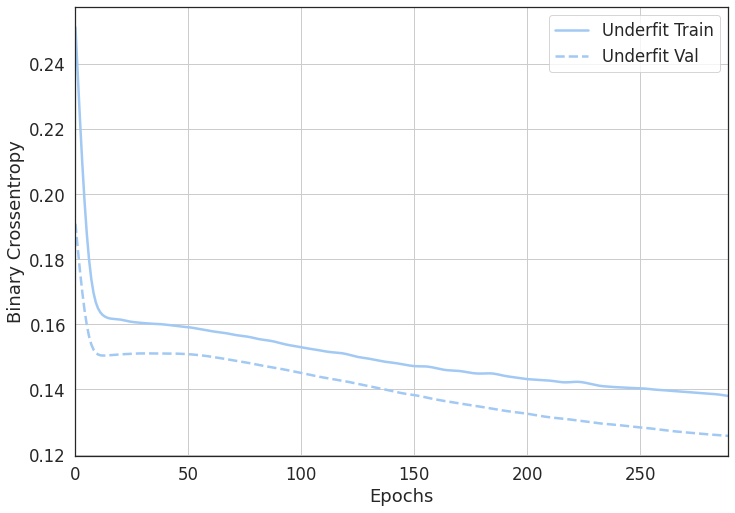

In [0]:
rnn_class_weight2.plot_training("binary_crossentropy")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    130870
           1       0.00      0.00      0.00      4370

    accuracy                           0.97    135240
   macro avg       0.48      0.50      0.49    135240
weighted avg       0.94      0.97      0.95    135240



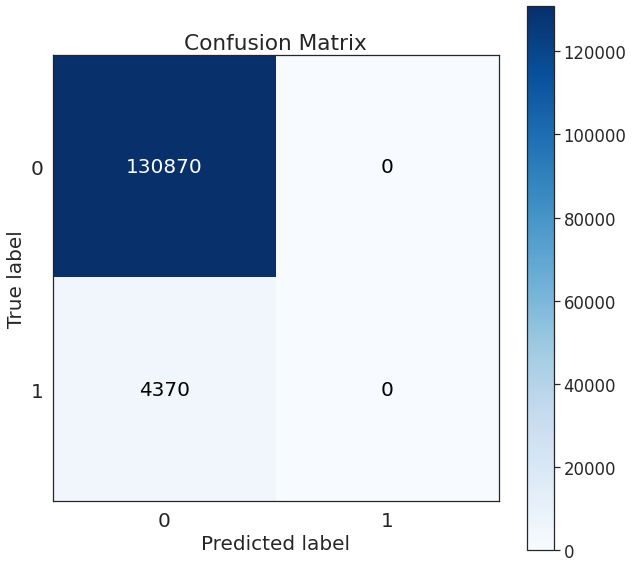

In [0]:
f1 = rnn_class_weight2.plot_evaluation(X_3d_train, y_3d_train)
f1_scores.update(f1)

In [0]:
# rnn model

model_class_weight3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(196,26),return_sequences=True),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,return_sequences=True)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Dense(1)
])

In [0]:
rnn_class_weight3 = rnn_constructor(model_class_weight3, "middle_fit", custom_loss_state = False)

In [0]:
hist = rnn_class_weight3.compile_and_fit(X_train = X_3d_train, y_train = y_3d_train,X_test = X_3d_test, y_test = y_3d_test, class_weight = True)
histories.update(hist)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 196, 32)           7552      
_________________________________________________________________
dropout_4 (Dropout)          (None, 196, 32)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 196, 32)           6272      
_________________________________________________________________
dropout_5 (Dropout)          (None, 196, 32)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 196, 1)            33        
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:0.4084,  loss:2.3026,  val_binary_crossentropy:0.1585,  val_loss:0.1585,  
..........

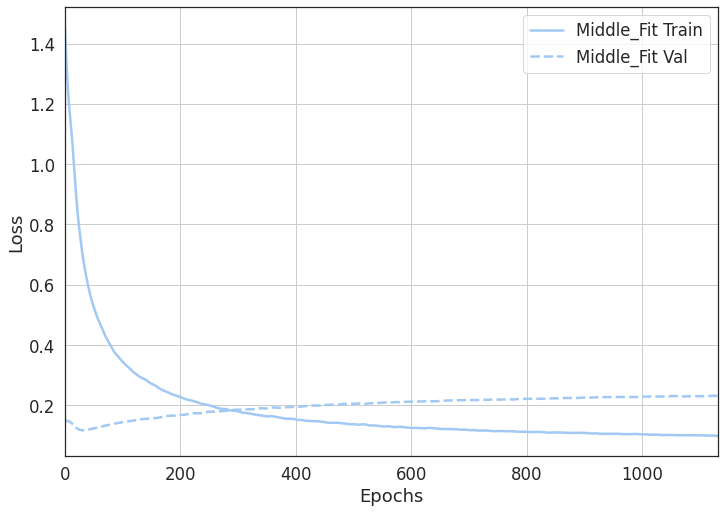

In [0]:
rnn_class_weight3.plot_training("loss")

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     43585
           1       0.22      0.22      0.22      1495

    accuracy                           0.95     45080
   macro avg       0.60      0.60      0.60     45080
weighted avg       0.95      0.95      0.95     45080



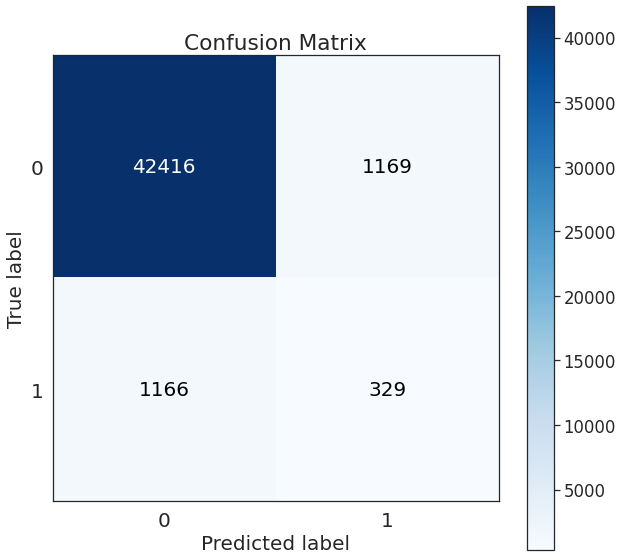

In [0]:
f1 = rnn_class_weight3.plot_evaluation(X_3d_val, y_3d_val)
f1_scores.update(f1)

In [0]:
# rnn model

model_class_loss_weight1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(196,26),return_sequences=True),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,return_sequences=True)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Dense(1)
])

In [0]:
rnn_class_loss_weight1 = rnn_constructor(model_class_loss_weight1, "class_loss_weight", custom_loss_state = True)

In [0]:
hist = rnn_class_loss_weight1.compile_and_fit(X_train = X_3d_train, y_train = y_3d_train,X_test = X_3d_test, y_test = y_3d_test, class_weight = True)
histories.update(hist)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 196, 8)            1120      
_________________________________________________________________
dropout_6 (Dropout)          (None, 196, 8)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 196, 16)           1088      
_________________________________________________________________
dropout_7 (Dropout)          (None, 196, 16)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 196, 1)            17        
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:0.6474,  loss:6.8931,  val_binary_crossentropy:0.6478,  val_loss:1.0176,  
............

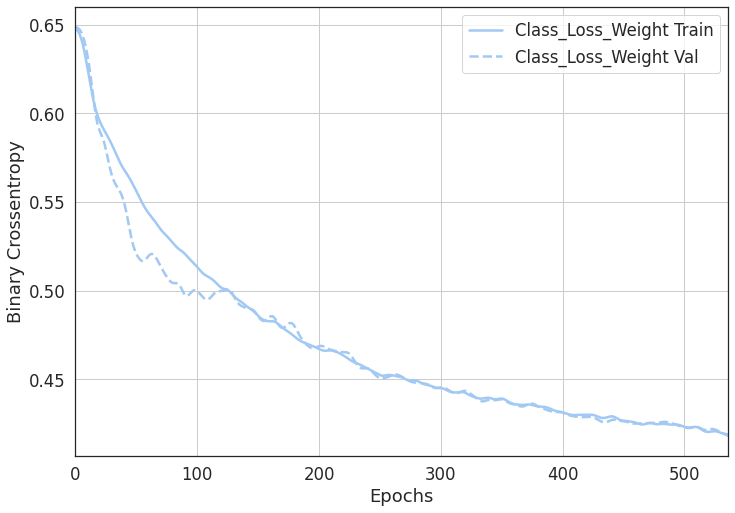

In [0]:
rnn_class_loss_weight1.plot_training("binary_crossentropy")

              precision    recall  f1-score   support

           0       0.98      0.84      0.90     43585
           1       0.11      0.57      0.18      1495

    accuracy                           0.83     45080
   macro avg       0.54      0.70      0.54     45080
weighted avg       0.95      0.83      0.88     45080



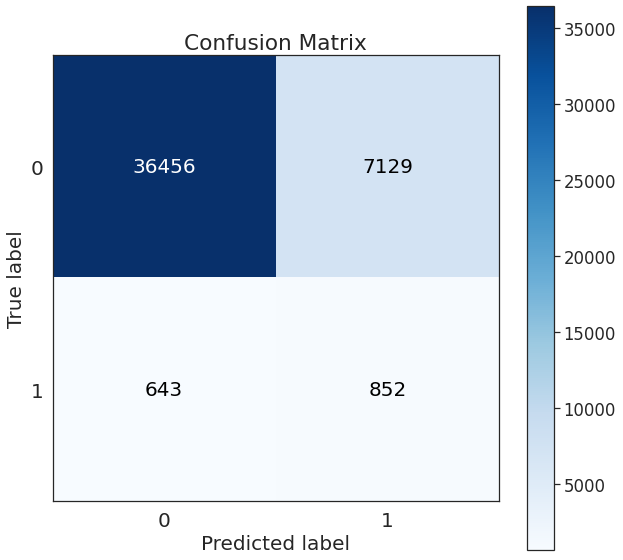

In [0]:
f1 = rnn_class_loss_weight1.plot_evaluation(X_3d_val, y_3d_val)
f1_scores.update(f1)

In [0]:
# rnn model

model_class_loss_weight2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(196,26),return_sequences=True),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Dense(1)
])

In [0]:
rnn_class_loss_weight2 = rnn_constructor(model_class_loss_weight2, "double_medium", custom_loss_state = True)

In [0]:
hist = rnn_class_loss_weight2.compile_and_fit(X_train = X_3d_train, y_train = y_3d_train,X_test = X_3d_test, y_test = y_3d_test, class_weight = True)
histories.update(hist)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 196, 32)           7552      
_________________________________________________________________
dropout_8 (Dropout)          (None, 196, 32)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 196, 64)           16640     
_________________________________________________________________
dropout_9 (Dropout)          (None, 196, 64)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 196, 1)            65        
Total params: 24,257
Trainable params: 24,257
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:0.6784,  loss:7.0853,  val_binary_crossentropy:0.6165,  val_loss:1.0061,  
..........

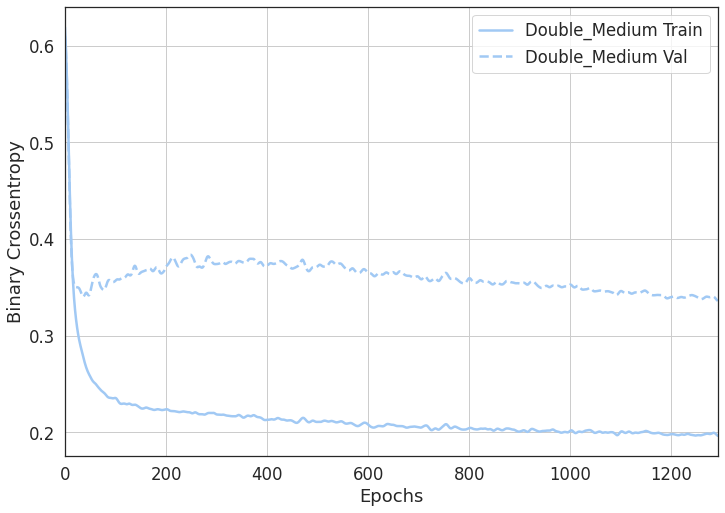

In [0]:
rnn_class_loss_weight2.plot_training("binary_crossentropy")

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     43585
           1       0.13      0.28      0.17      1495

    accuracy                           0.91     45080
   macro avg       0.55      0.61      0.56     45080
weighted avg       0.95      0.91      0.93     45080



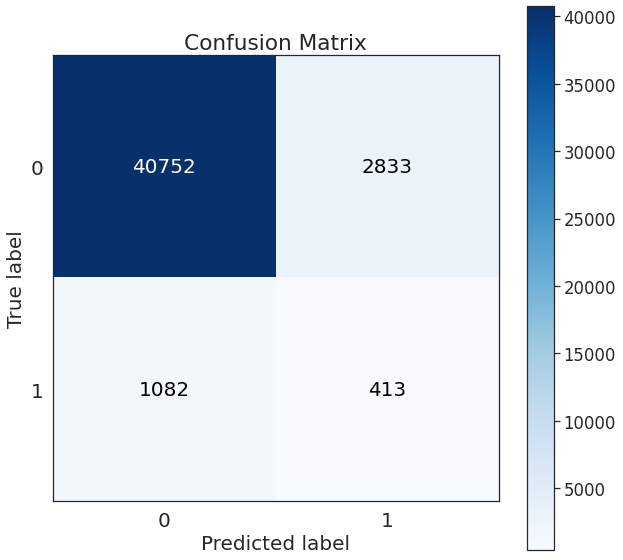

In [0]:
f1 = rnn_class_loss_weight2.plot_evaluation(X_3d_val, y_3d_val)
f1_scores.update(f1)

In [0]:
# rnn model

model_class_loss_weight3 = tf.keras.Sequential([
    #tf.keras.layers.LSTM(8, input_shape=(196,26),return_sequences=True),
    #tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True), input_shape=(196,26)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

In [0]:
rnn_class_loss_weight3 = rnn_constructor(model_class_loss_weight3, "double_small_timedistributed", custom_loss_state = True)

In [0]:
hist = rnn_class_loss_weight3.compile_and_fit(X_train = X_3d_train, y_train = y_3d_train,X_test = X_3d_test, y_test = y_3d_test, class_weight = True)
histories.update(hist)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 196, 40)           7520      
_________________________________________________________________
dropout_10 (Dropout)         (None, 196, 40)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 196, 1)            41        
Total params: 7,561
Trainable params: 7,561
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:0.7591,  loss:7.4812,  val_binary_crossentropy:0.6067,  val_loss:0.9628,  
....................................................................................................
Epoch: 100, binary_crossentropy:0.2675,  loss:2.0647,  val_binary_crossentropy:0.2846,  val_loss:0.5694,  
....................................................................

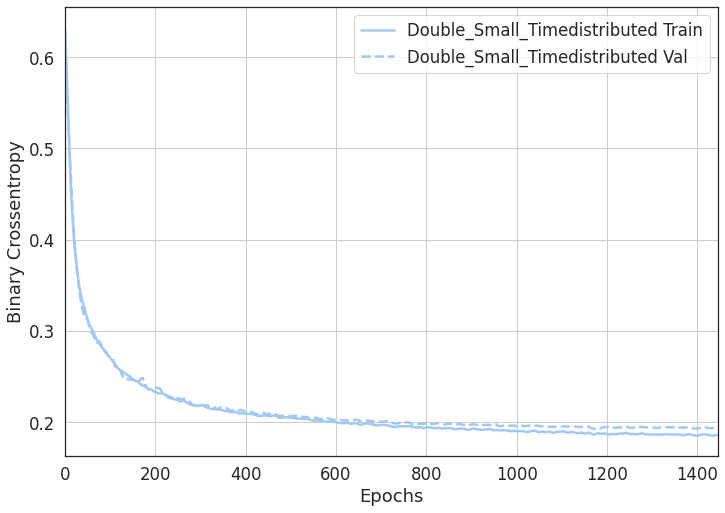

In [0]:
rnn_class_loss_weight3.plot_training("binary_crossentropy")

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     43585
           1       0.17      0.41      0.24      1495

    accuracy                           0.92     45080
   macro avg       0.58      0.67      0.60     45080
weighted avg       0.95      0.92      0.93     45080



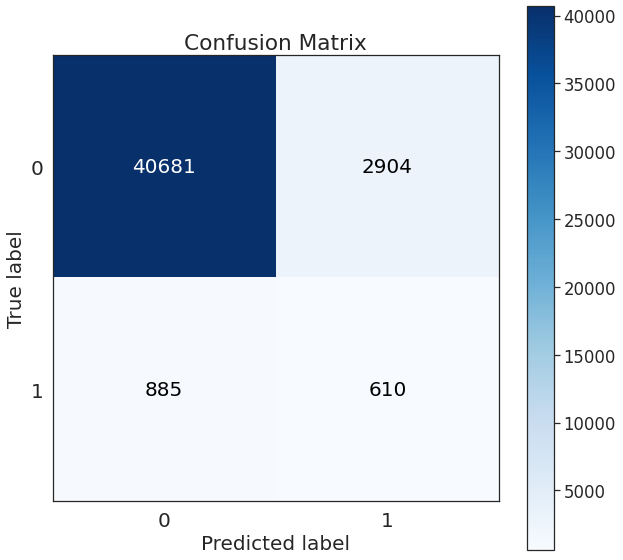

In [0]:
f1 = rnn_class_loss_weight3.plot_evaluation(X_3d_val, y_3d_val)
f1_scores.update(f1)

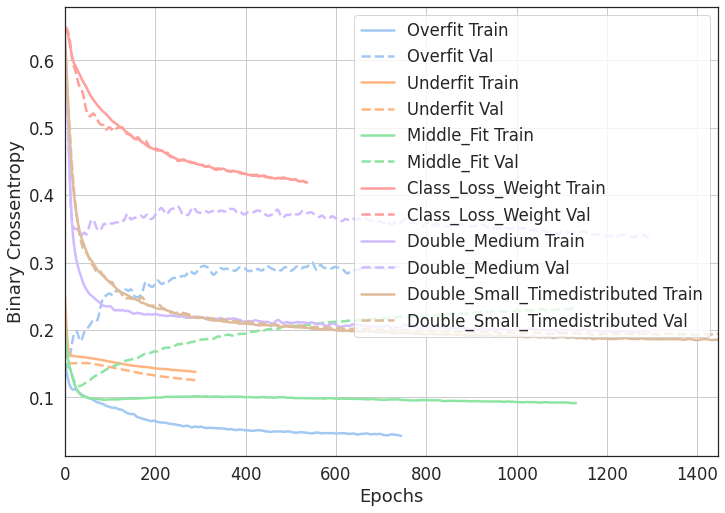

In [0]:
plotter = tfdocs.plots.HistoryPlotter(metric = "binary_crossentropy", smoothing_std=10)
plotter.plot(histories)

# rnn not combined with reduced dataframe

In [0]:
# function to get dataframe into x and y array with format (reads, ref_pos, features) to be able use ref_pos
# as time step in rnn

def prepare_rnn_data2 (df):
     
    # dummify base sequence and concatenate into temp dataframe with numeric values from source dataframe
    
    df_dum = pd.get_dummies(df[["base_1"]])
    df_dum = pd.concat([df, df_dum], axis = 1)
    df_dum = df_dum.drop(["base_1"], axis = 1)
    
    df_dum_num = df_dum[df_dum.select_dtypes(include=[np.number]).columns.values]
    
    # feature 3d array:
    # nested for loop over file name, ref_num and read_num to iterate over every unique possible read and concatenate
    # x and y values into a list of lists
    
    X = []
    y= []
    
    for file_name in df_dum.file_name.unique():
        msk1 = df_dum[df_dum.file_name == file_name]
        for ref_num in msk1.ref_number.unique():
            msk2 = msk1[msk1.ref_number == ref_num]
            for read_num in msk2.read_num.unique():
                msk3 = (df_dum.file_name == file_name) & (df_dum.ref_number == ref_num) & (df_dum.read_num == read_num)
                X.append(df_dum_num[msk3])
                y.append(df_dum[msk3].modified_status.astype(int))
  
    #stack resulting lists into a 3d numpy array
    
    X = np.stack(X)
    y = np.stack(y)
    
    return X, y

In [0]:
df_reduced = df_not_combined[["file_name","ref_number","read_num","ref_pos","dwell_time","dwell_time_rolling_min","base_1","modified_status"]]

In [0]:
# prepare whole dataframe subsets according to train test split

df_finaltest_reduced = df_reduced[df_reduced["ref_number"].isin(final_ref)]
df_val_reduced = df_reduced[df_reduced["ref_number"].isin(val_ref)]
df_train_reduced = df_reduced[df_reduced["ref_number"].isin(train_ref)]
df_test_reduced = df_reduced[df_reduced["ref_number"].isin(test_ref)]

In [0]:
# prepare each dataframe combination with function

X_reduced_train, y_reduced_train = prepare_rnn_data2(df_train_reduced)
X_reduced_test, y_reduced_test = prepare_rnn_data2(df_test_reduced)
X_reduced_finaltest, y_reduced_finaltest = prepare_rnn_data2(df_finaltest_reduced)
X_reduced_val, y_reduced_val = prepare_rnn_data2(df_val_reduced)

In [0]:
X_reduced_train.shape

(690, 196, 6)

In [0]:
# rnn model

model_reduced1 = tf.keras.Sequential([
  
    #tf.keras.layers.LSTM(8, input_shape=(196,26),return_sequences=True),
    #tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True), input_shape=(196,6)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

In [0]:
rnn_reduced1 = rnn_constructor(model_reduced1, "reduced1", custom_loss_state = True)

In [0]:
hist = rnn_reduced1.compile_and_fit(X_train = X_reduced_train, y_train = y_reduced_train, X_test = X_reduced_test, y_test = y_reduced_test, class_weight = True)
histories.update(hist)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 196, 40)           4320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 196, 40)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 196, 1)            41        
Total params: 4,361
Trainable params: 4,361
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:0.6610,  loss:6.8842,  val_binary_crossentropy:0.6148,  val_loss:0.9775,  
....................................................................................................
Epoch: 100, binary_crossentropy:0.2498,  loss:0.6768,  val_binary_crossentropy:0.4228,  val_loss:1.4416,  
....................................................................

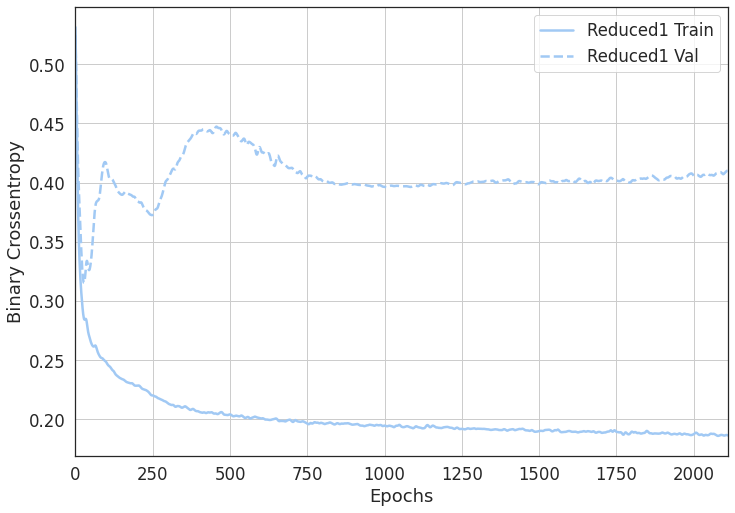

In [0]:
rnn_reduced1.plot_training("binary_crossentropy")

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     43585
           1       0.04      0.08      0.05      1495

    accuracy                           0.91     45080
   macro avg       0.51      0.51      0.50     45080
weighted avg       0.94      0.91      0.92     45080



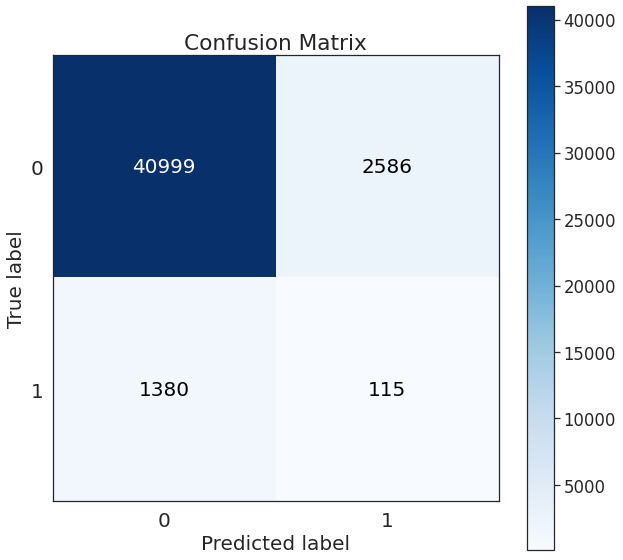

In [0]:
f1 = rnn_reduced1.plot_evaluation(X_reduced_val, y_reduced_val)
f1_scores.update(f1)

In [0]:
# rnn model

model_reduced2 = tf.keras.Sequential([
  
    #tf.keras.layers.LSTM(8, input_shape=(196,26),return_sequences=True),
    #tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10,return_sequences=True), input_shape=(196,6)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

In [0]:
rnn_reduced2 = rnn_constructor(model_reduced2, "reduced1", custom_loss_state = True)

In [0]:
hist = rnn_reduced2.compile_and_fit(X_train = X_reduced_train, y_train = y_reduced_train, X_test = X_reduced_test, y_test = y_reduced_test, class_weight = True)
histories.update(hist)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 196, 20)           1360      
_________________________________________________________________
dropout_12 (Dropout)         (None, 196, 20)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 196, 1)            21        
Total params: 1,381
Trainable params: 1,381
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:0.6409,  loss:6.5927,  val_binary_crossentropy:0.6097,  val_loss:0.9595,  
....................................................................................................
Epoch: 100, binary_crossentropy:0.2476,  loss:0.9865,  val_binary_crossentropy:0.3300,  val_loss:0.9991,  
....................................................................

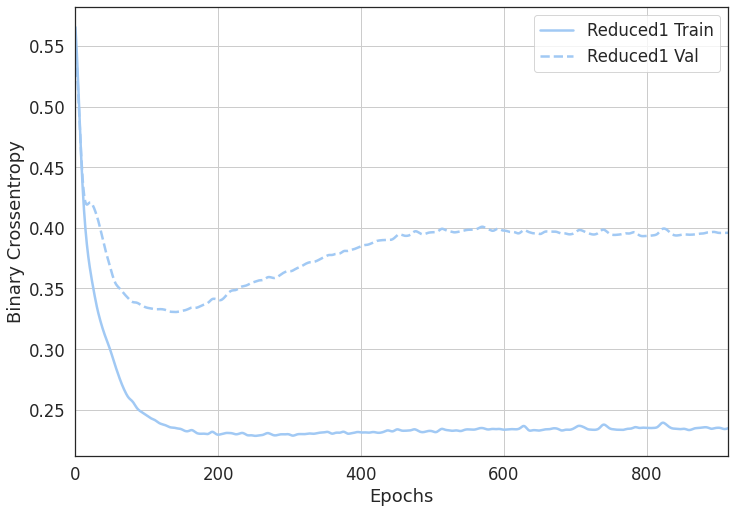

In [0]:
rnn_reduced2.plot_training("binary_crossentropy")

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     43585
           1       0.20      0.47      0.28      1495

    accuracy                           0.92     45080
   macro avg       0.59      0.70      0.62     45080
weighted avg       0.95      0.92      0.93     45080



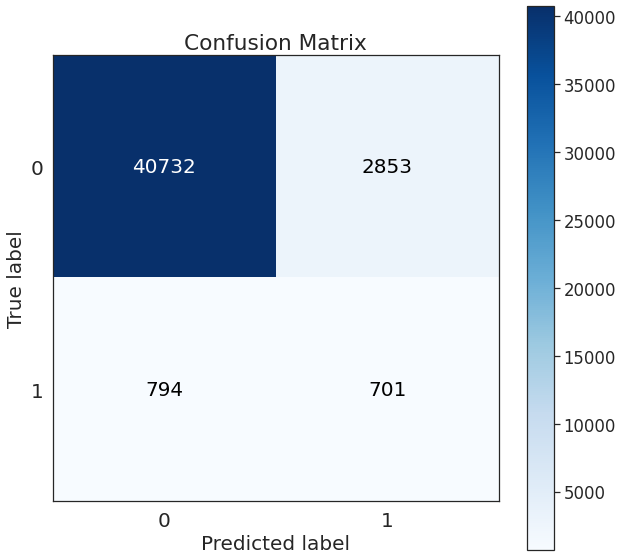

In [0]:
f1 = rnn_reduced2.plot_evaluation(X_reduced_val, y_reduced_val)
f1_scores.update(f1)

# rnn combined

In [0]:
X_combined_test.shape

(4, 196, 35)

In [0]:
# rnn model

model_combined_both = tf.keras.Sequential([
    #tf.keras.layers.LSTM(8, input_shape=(196,26),return_sequences=True),
    #tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25,return_sequences=True), input_shape=(196,35)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

In [0]:
rnn_combined_both = rnn_constructor(model_combined_both, "combined_both", batch_size=4, custom_loss_state = True)

In [0]:
rnn_combined_both.batch_size

4

In [0]:
hist = rnn_combined_both.compile_and_fit(X_train = X_combined_train, y_train = y_combined_train,X_test = X_combined_test, y_test = y_combined_test, class_weight = True)
histories.update(hist)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 196, 50)           12200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 196, 50)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 196, 1)            51        
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, binary_crossentropy:1.0509,  loss:7.9935,  val_binary_crossentropy:0.8681,  val_loss:1.1466,  
....................................................................................................
Epoch: 100, binary_crossentropy:0.5411,  loss:5.4960,  val_binary_crossentropy:0.5339,  val_loss:1.0354,  
..................................................................

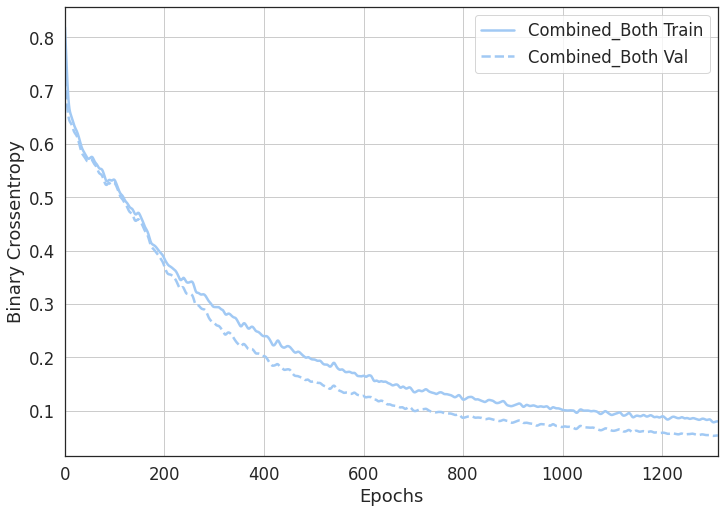

In [0]:
rnn_combined_both.plot_training("binary_crossentropy")

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       758
           1       0.85      0.88      0.87        26

    accuracy                           0.99       784
   macro avg       0.92      0.94      0.93       784
weighted avg       0.99      0.99      0.99       784



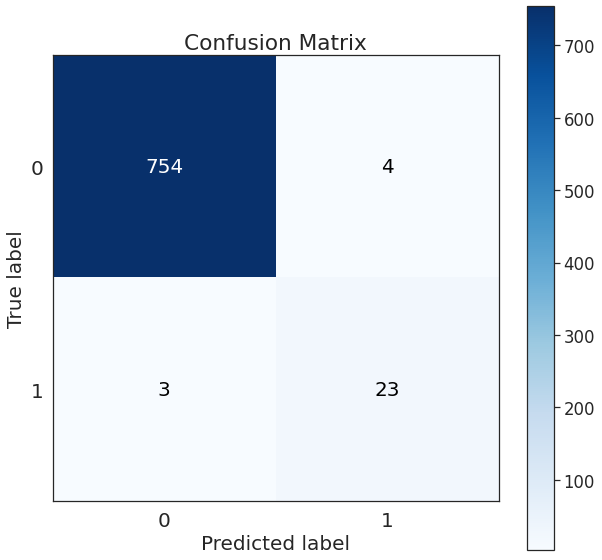

In [0]:
f1 = rnn_combined_both.plot_evaluation(X_combined_val, y_combined_val)
f1_scores.update(f1)

# traditional ann

In [0]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
X_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
y_finaltest_not_combined = X_finaltest_not_combined.pop("modified_status")
X_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
y_val_not_combined = X_val_not_combined.pop("modified_status")
X_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
y_train_not_combined = X_train_not_combined.pop("modified_status")
X_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]
y_test_not_combined = X_test_not_combined.pop("modified_status")

In [0]:
numeric_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "float"])

numeric_features_not_combined

cat_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "category"])

cat_features_not_combined

#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_not_combined = SimpleImputer(strategy="median")
scaler1_not_combined = StandardScaler()
numeric_transformer_not_combined = make_pipeline(imputer1_not_combined,scaler1_not_combined)


imputer2_not_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_not_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_not_combined = make_pipeline(imputer2_not_combined,encoder_not_combined)

preprocessor_not_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined),
        ('cat', cat_transformer_not_combined, cat_features_not_combined)
    ])